In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from src.logit_graph import simulation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import powerlaw
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams.update({'figure.figsize': (12, 8), 'font.size': 10})

## Helper Functions

In [3]:
def test_power_law_fit(G):
    """Test if degree distribution follows a power-law (Clauset-Shalizi-Newman method)."""
    result = {'power_law_alpha': np.nan, 'xmin': np.nan, 'ks_statistic': np.nan,
              'loglikelihood_ratio': np.nan, 'compare_p_value': np.nan,
              'is_scale_free': False, 'min_degree': 0, 'max_degree': 0}

    degrees = [d for _, d in G.degree() if d > 0]
    if len(degrees) < 30:
        return result

    fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
    # Compare power-law vs exponential (positive R => power-law preferred)
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

    return {
        'power_law_alpha': fit.alpha,
        'xmin': fit.xmin,
        'ks_statistic': fit.power_law.KS(data=degrees),
        'loglikelihood_ratio': R,
        'compare_p_value': p,
        'is_scale_free': R > 0 and p < 0.05,
        'min_degree': min(degrees),
        'max_degree': max(degrees),
    }


def analyze_graph(G):
    """Return a dict of key graph properties."""
    n, m = G.number_of_nodes(), G.number_of_edges()
    props = {
        'n_nodes': n, 'n_edges': m,
        'density': nx.density(G),
        'avg_degree': 2 * m / n if n > 0 else 0,
        'clustering_coefficient': nx.average_clustering(G) if m > 0 else 0.0,
    }
    props.update(test_power_law_fit(G))
    return props

## Parameter Sweep

In [4]:
def run_parameter_sweep(n=100, n_iterations=5000, patience=1000,
                        n_repeats=3, warm_up=20, er_p=0.001):
    """Sweep over sigma and d values, collecting graph properties."""
    sigma_values = [-5, -2, -1, -0.5, 0, 0.5, 1.0, 2.0]
    d_values = [0, 1, 2]

    results = []
    total = len(sigma_values) * len(d_values) * n_repeats

    for sigma in tqdm(sigma_values, desc='sigma'):
        for d in d_values:
            for repeat in range(n_repeats):
                try:
                    sim = simulation.LogitGraphSimulation(
                        n=n, d=d, sigma=sigma,
                        alpha=1.0, beta=1.0, er_p=er_p,
                        n_iteration=n_iterations,
                        warm_up=warm_up, patience=patience,
                        verbose=False,
                    )
                    sim.simulate()

                    if sim.simulated_graph is not None:
                        props = analyze_graph(sim.simulated_graph)
                        results.append({'sigma': sigma, 'd': d, 'repeat': repeat, **props})
                except Exception as e:
                    print(f'Error (sigma={sigma}, d={d}, repeat={repeat}): {e}')

    return pd.DataFrame(results)

## Run Experiment

In [ ]:
results_df = run_parameter_sweep(
    n=200,
    n_iterations=10000,
    warm_up=2000,
    er_p=0.01,
    patience=500,
    n_repeats=3,
)
results_df.head()

sigma:   0%|          | 0/8 [00:00<?, ?it/s]

Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Error (sigma=-5, d=0, repeat=0): name 'compute_distance_metrics' is not defined


Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

Error (sigma=-5, d=0, repeat=1): name 'compute_distance_metrics' is not defined


Generating graph:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(f'Experiments: {len(results_df)}')
print(f'Clustering coeff: {results_df["clustering_coefficient"].mean():.4f} \u00b1 {results_df["clustering_coefficient"].std():.4f}')
print(f'Scale-free proportion: {results_df["is_scale_free"].mean():.2%}')
print(f'Avg degree: {results_df["avg_degree"].mean():.2f} \u00b1 {results_df["avg_degree"].std():.2f}')

Experiments: 0


KeyError: 'clustering_coefficient'

## Analysis

In [ ]:
agg = results_df.groupby(['sigma', 'd']).agg({
    'clustering_coefficient': ['mean', 'std'],
    'power_law_alpha': ['mean', 'std'],
    'ks_statistic': ['mean', 'std'],
    'loglikelihood_ratio': ['mean', 'std'],
    'is_scale_free': 'mean',
    'avg_degree': 'mean',
    'density': 'mean',
    'n_edges': 'mean',
}).reset_index()
agg.columns = ['_'.join(c).strip('_') for c in agg.columns]
agg.head(12)

### Clustering Coefficient vs Sigma

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for d in sorted(agg['d'].unique()):
    sub = agg[agg['d'] == d]
    ax.errorbar(sub['sigma'], sub['clustering_coefficient_mean'],
                yerr=sub['clustering_coefficient_std'],
                marker='o', label=f'd={d}', capsize=5, linewidth=2)
ax.set(xlabel='Sigma (\u03c3)', ylabel='Clustering Coefficient',
       title='Clustering Coefficient vs Sigma')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Scale-Free Property vs Sigma

NameError: name 'agg' is not defined

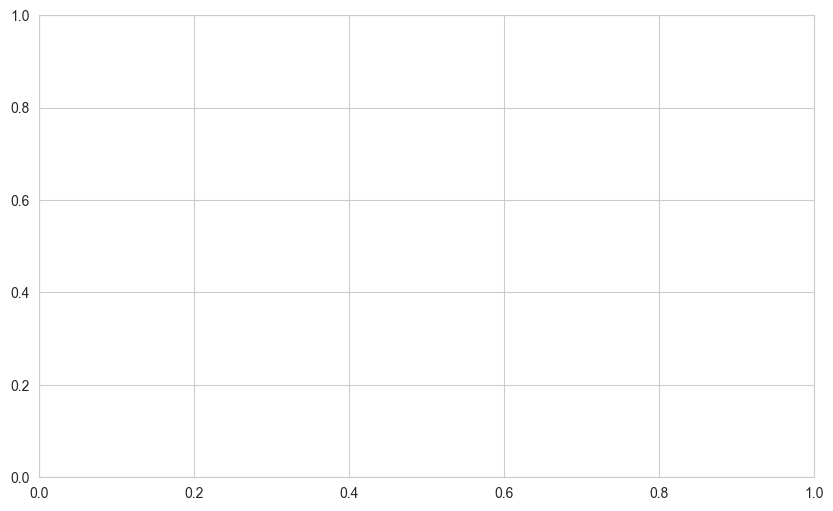

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for d in sorted(agg['d'].unique()):
    sub = agg[agg['d'] == d]
    ax.plot(sub['sigma'], sub['is_scale_free_mean'],
            marker='o', label=f'd={d}', linewidth=2, markersize=8)
ax.axhline(0.5, color='red', ls='--', alpha=0.3, label='50% threshold')
ax.set(xlabel='Sigma (\u03c3)', ylabel='Proportion Scale-Free', ylim=(-0.05, 1.05),
       title='Scale-Free Property vs Sigma')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Power-Law Exponent vs Sigma

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for d in sorted(agg['d'].unique()):
    sub = agg[agg['d'] == d]
    ax.errorbar(sub['sigma'], sub['power_law_alpha_mean'],
                yerr=sub['power_law_alpha_std'],
                marker='o', label=f'd={d}', capsize=5, linewidth=2)
ax.axhspan(2.0, 3.0, alpha=0.1, color='red', label='Typical range (2-3)')
ax.set(xlabel='Sigma (\u03c3)', ylabel='Power-Law Exponent (\u03b1)',
       title='Power-Law Exponent vs Sigma')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Heatmaps: Scale-Free & Clustering

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

pivot_sf = agg.pivot_table('is_scale_free_mean', index='sigma', columns='d')
pivot_cc = agg.pivot_table('clustering_coefficient_mean', index='sigma', columns='d')

sns.heatmap(pivot_sf, annot=True, fmt='.2f', cmap='YlOrRd',
            vmin=0, vmax=1, linewidths=.5, ax=ax1,
            cbar_kws={'label': 'Proportion Scale-Free'})
ax1.set(title='Scale-Free Property', xlabel='d', ylabel='Sigma (\u03c3)')

sns.heatmap(pivot_cc, annot=True, fmt='.3f', cmap='viridis',
            linewidths=.5, ax=ax2,
            cbar_kws={'label': 'Clustering Coefficient'})
ax2.set(title='Clustering Coefficient', xlabel='d', ylabel='Sigma (\u03c3)')

plt.tight_layout()
plt.show()

### Correlation Matrix

In [ ]:
corr_cols = ['sigma', 'd', 'clustering_coefficient_mean', 'is_scale_free_mean',
             'power_law_alpha_mean', 'loglikelihood_ratio_mean', 'avg_degree_mean', 'density_mean']
corr = agg[corr_cols].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', linewidths=1)
plt.title('Correlation Matrix: Parameters vs Network Properties')
plt.tight_layout()
plt.show()

### Statistical Summary

In [ ]:
# Configurations with high clustering AND scale-free properties
cc_thresh = agg['clustering_coefficient_mean'].quantile(0.75)
sf_thresh = 0.5

interesting = agg[
    (agg['clustering_coefficient_mean'] > cc_thresh) &
    (agg['is_scale_free_mean'] > sf_thresh)
].sort_values('clustering_coefficient_mean', ascending=False)

show_cols = ['sigma', 'd', 'clustering_coefficient_mean', 'is_scale_free_mean',
             'power_law_alpha_mean', 'avg_degree_mean']

if len(interesting) > 0:
    print(f'Configs with clustering > {cc_thresh:.4f} and scale-free > {sf_thresh}:')
    print(interesting[show_cols].to_string(index=False))
else:
    print('No configs meet both criteria. Relaxing thresholds...')
    relaxed = agg[
        (agg['clustering_coefficient_mean'] > agg['clustering_coefficient_mean'].quantile(0.5)) &
        (agg['is_scale_free_mean'] > 0.3)
    ].sort_values('clustering_coefficient_mean', ascending=False)
    if len(relaxed) > 0:
        print(relaxed[show_cols].to_string(index=False))
    else:
        print('Still no matches.')